In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



In [ ]:
# Step 1: Install Kaggle and set up authentication
!pip install -q kaggle

import json
import os

# Create kaggle.json with your credentials
kaggle_token = {"username":"shivanjalijagtap18","key":"86ead3e7dad96c34074f92f13aeb3eef"}
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(kaggle_token, file)

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

# Step 2: Download and unzip dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d /content/alzheimer_dataset



Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0
  0% 0.00/71.5M [00:00<?, ?B/s]
100% 71.5M/71.5M [00:00<00:00, 1.21GB/s]


Visualizing sample MRI scans with brain region heatmaps...


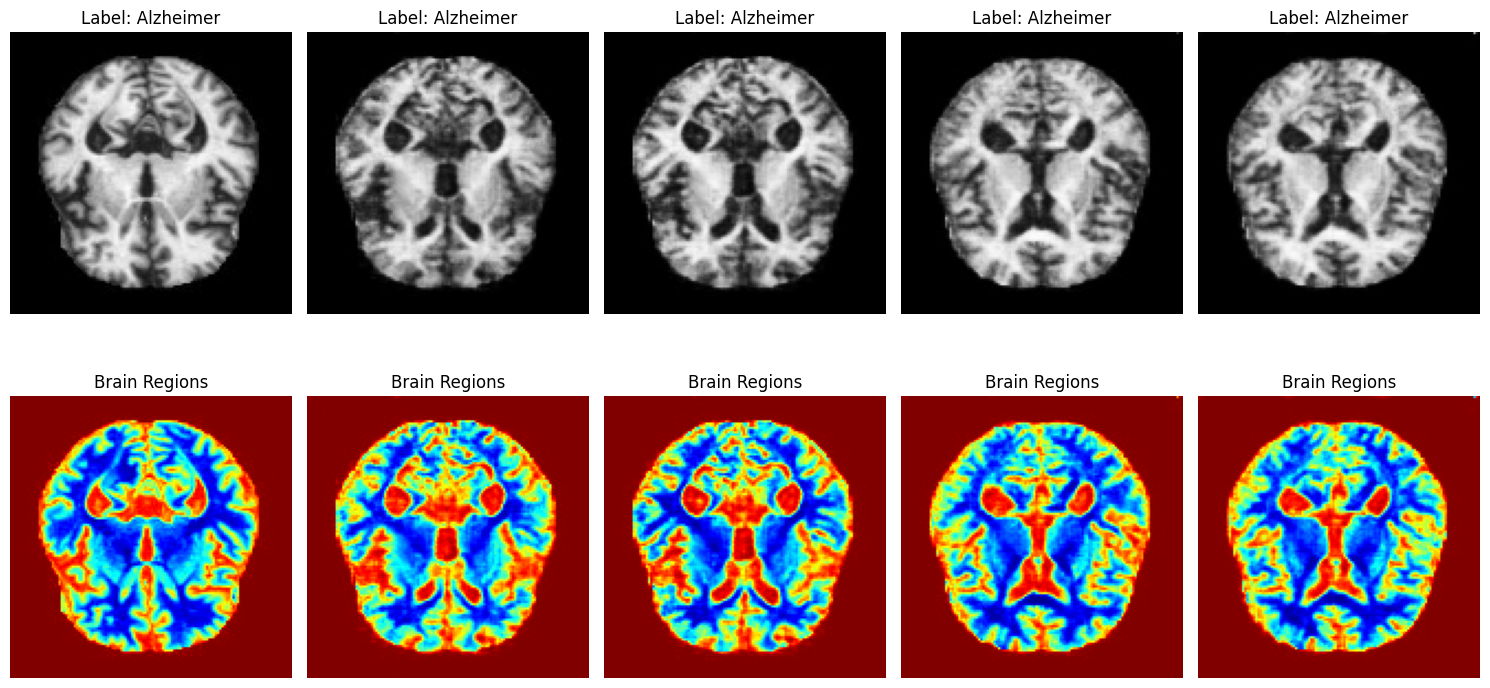

In [ ]:
# === 1. Map folder names to labels ===
label_map = {
    'Mild Impairment': 1,
    'Moderate Impairment': 1,
    'Very Mild Impairment': 1,
    'No Impairment': 0
}

# === 2. Load image paths and labels ===
def load_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []
    class_names = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(folder_path, img_name)
                image_paths.append(full_path)
                labels.append(label_map[folder])
                class_names.append(img_name)
    return image_paths, labels, class_names

# === 3. Visualize sample images ===
def visualize_sample_images(image_paths, labels, num_samples=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {'Alzheimer' if labels[i] else 'Normal'}")
        plt.axis('off')

        # Show brain regions with heatmap
        plt.subplot(2, num_samples, i+num_samples+1)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        heatmap = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
        plt.imshow(heatmap)
        plt.title("Brain Regions")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# === Main execution ===
if __name__ == "__main__":
    # Set your dataset directory
    train_dir = "/content/alzheimer_dataset/Combined Dataset/train"

    # Load image paths and labels
    image_paths, labels, _ = load_image_paths_and_labels(train_dir)

    # Visualize sample images with heatmaps
    print("Visualizing sample MRI scans with brain region heatmaps...")
    visualize_sample_images(image_paths, labels)

In [ ]:
# === 4. Load and preprocess image data ===
def load_mri_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # MobileNetV2 specific preprocessing
        images.append(img)
    return np.array(images)

def load_tabular_data(csv_path, num_rows, scaler=None):
    df = pd.read_csv(csv_path)
    df['label'] = df['Group'].map({'Demented': 1, 'Nondemented': 0, 'Converted': 1})
    df['gender'] = df['M/F'].map({'M': 1, 'F': 0})
    df.drop(columns=['Group', 'M/F'], inplace=True)

    # Fill missing values
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].mean())

    # Only take required rows
    df = df[:num_rows]

    X = df.drop("label", axis=1)
    y = df["label"]

    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, y.values, scaler


In [ ]:
# === 5. Image model with feature visualization ===
def create_image_model():
    base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    # Create a model that outputs both the final features and intermediate layers
    layer_outputs = [base_model.get_layer('block_6_expand_relu').output,
                    base_model.get_layer('block_13_expand_relu').output,
                    base_model.output]

# === 5. Image model with feature visualization ===
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

def create_image_model():
    base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    # Create a model that outputs both the final features and intermediate layers
    layer_outputs = [base_model.get_layer('block_6_expand_relu').output,
                    base_model.get_layer('block_13_expand_relu').output,
                    base_model.output]

    return Model(inputs=base_model.input, outputs=layer_outputs)

def visualize_feature_maps(model, img_array, layer_names):
    pass # Function body was missing

Using sample image: /content/alzheimer_dataset/Combined Dataset/train/Moderate Impairment/ModerateImpairment (6).jpg

Generating feature maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


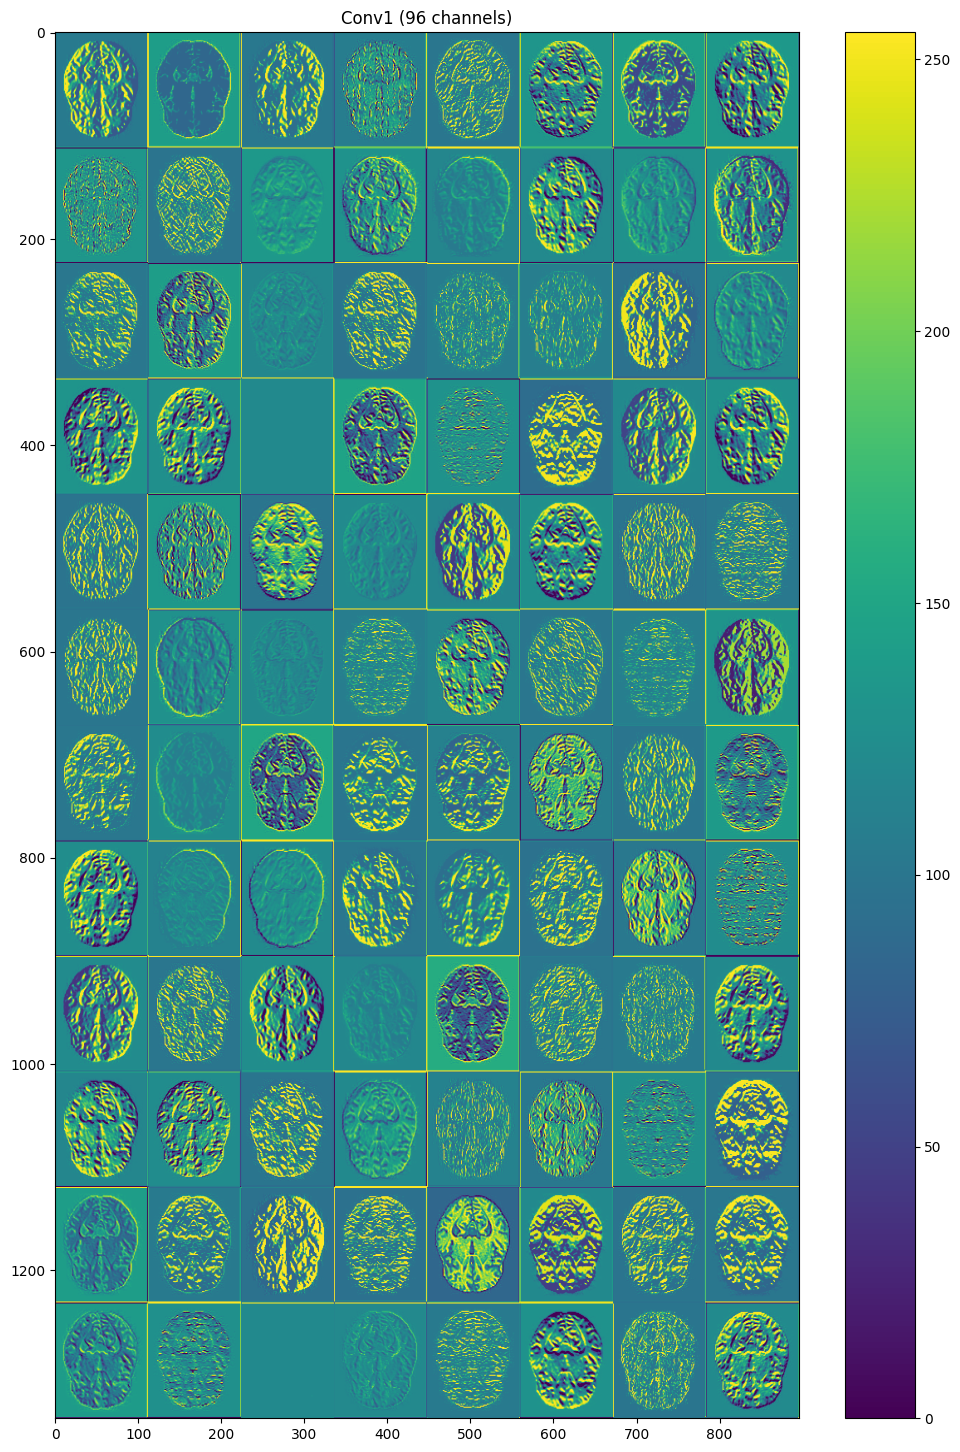

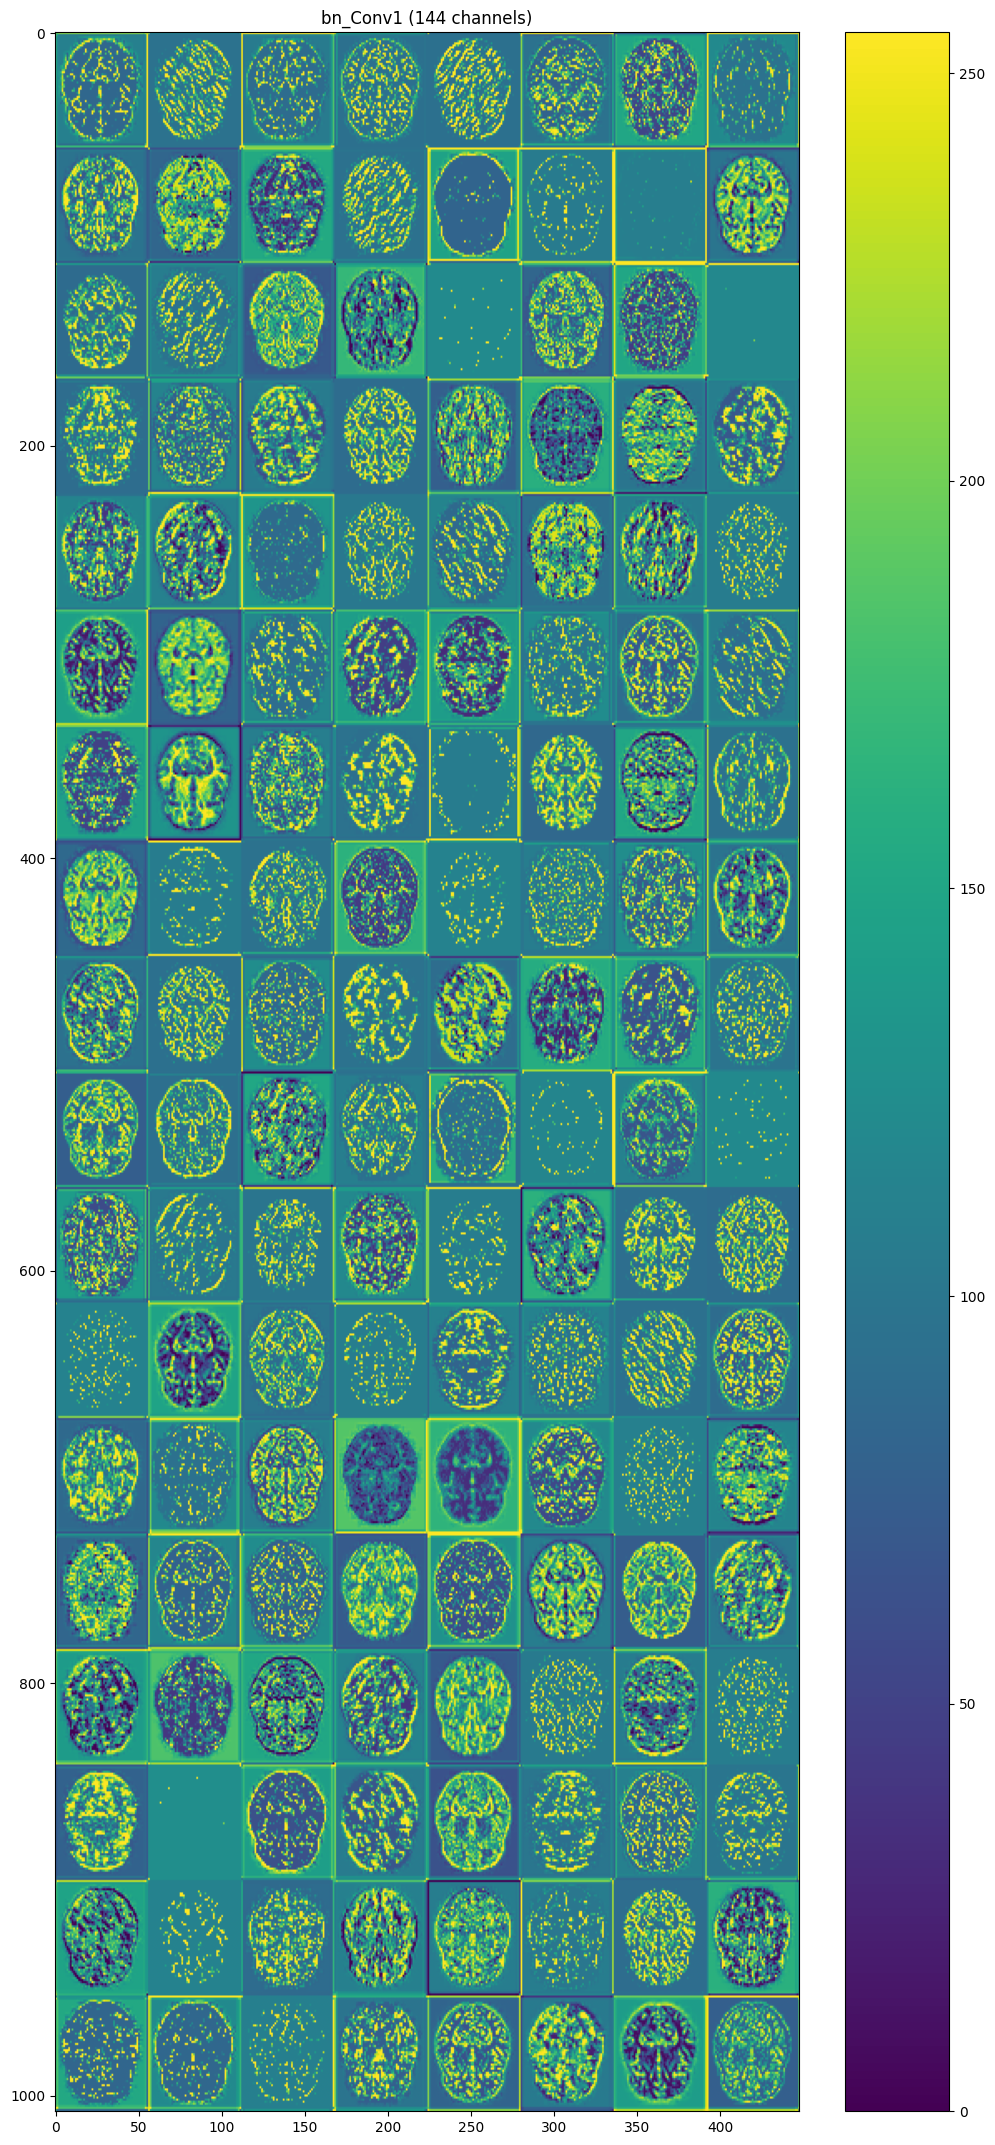

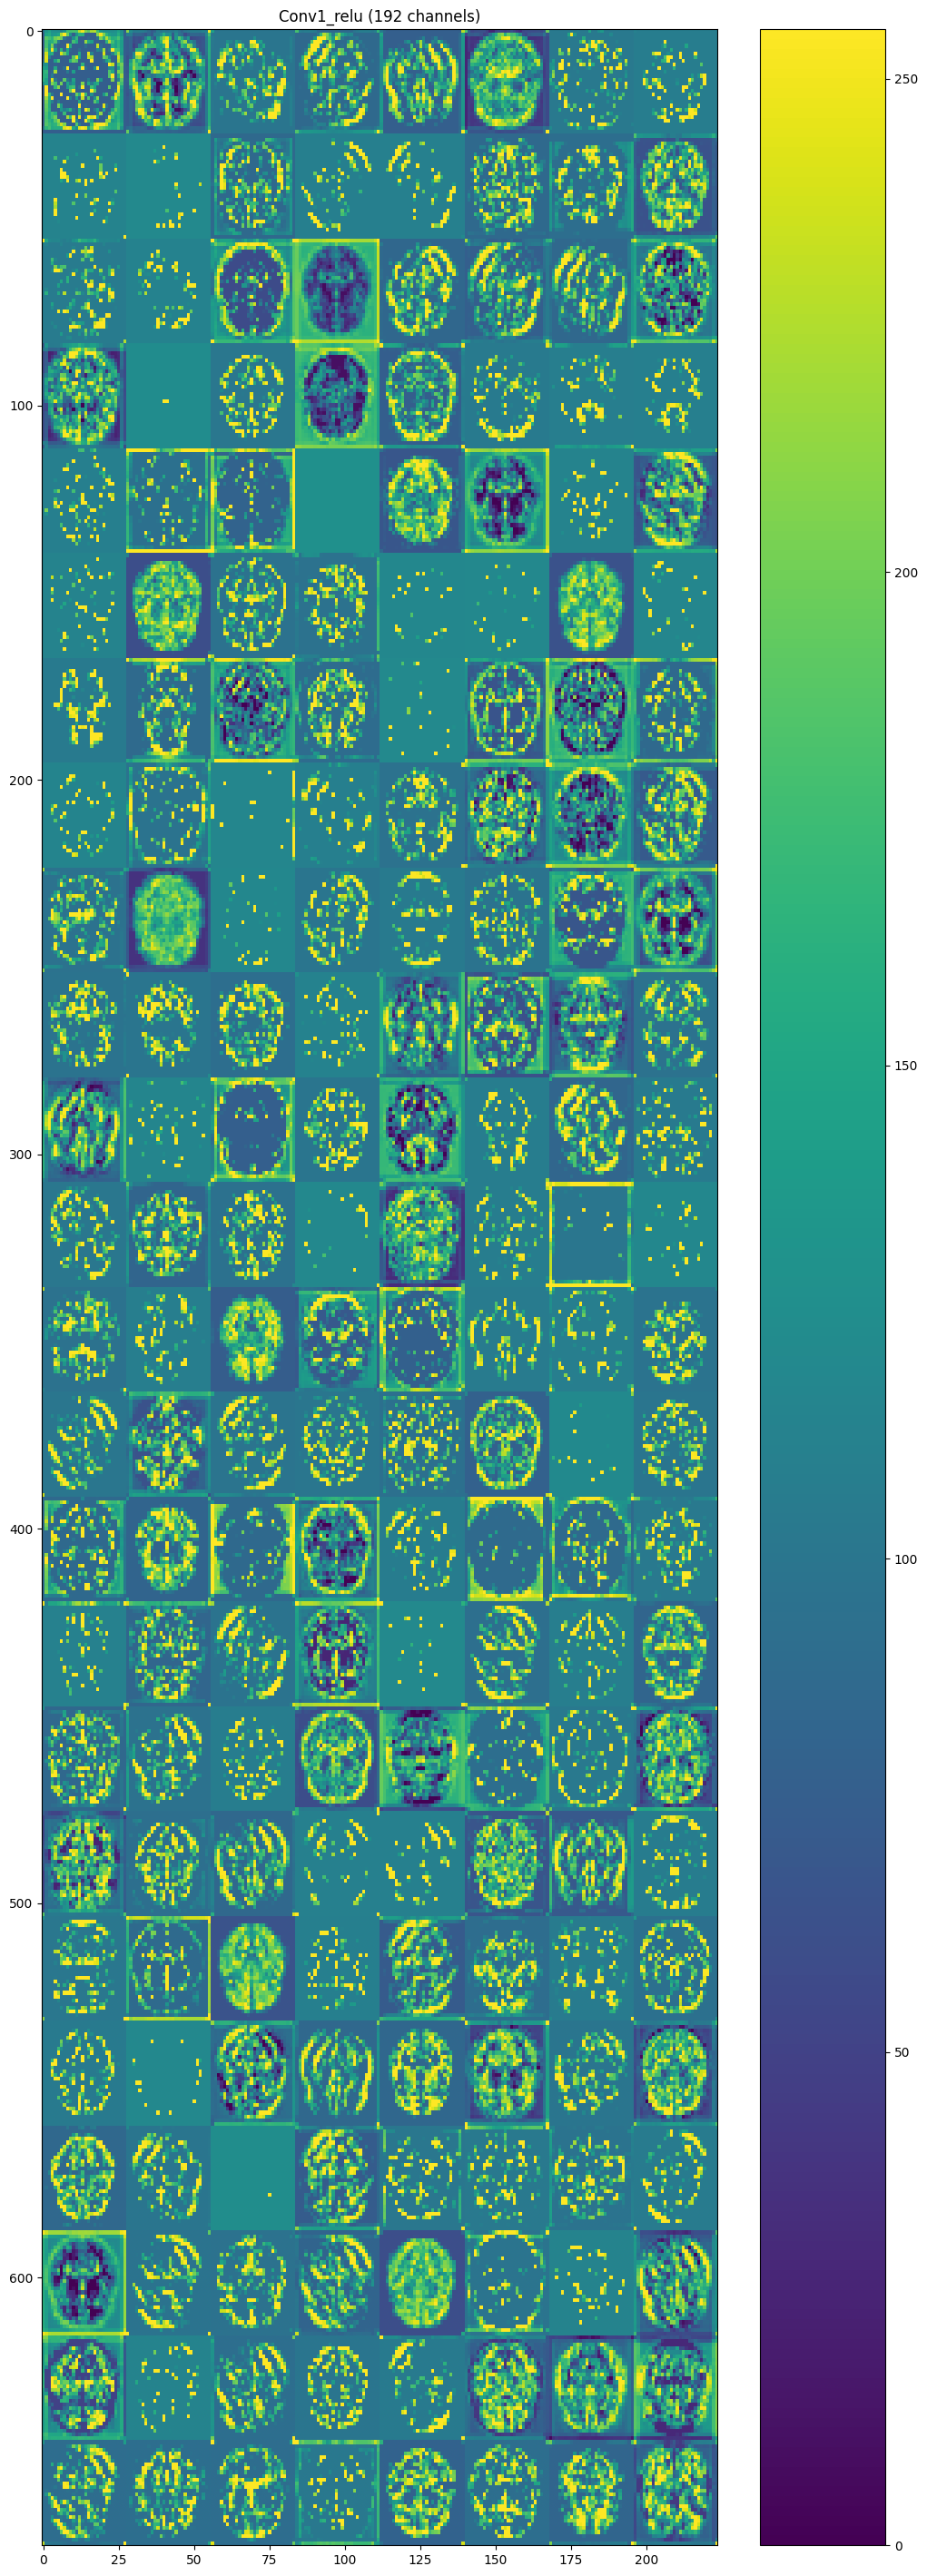

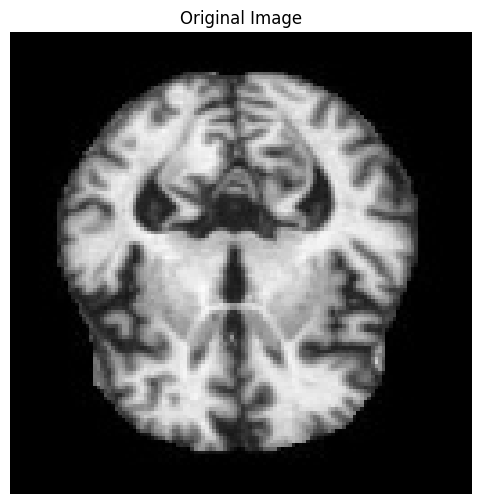

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

def create_image_model():
    base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    # Good layers for visualization
    layer_names = ['block_1_expand_relu',  # Simple features
                   'block_3_expand_relu',  # Mid-level
                   'block_6_expand_relu']  # Complex features
    layer_outputs = [base_model.get_layer(name).output for name in layer_names]
    return Model(inputs=base_model.input, outputs=layer_outputs)

def find_valid_image(base_dir):
    """Find first valid image in the dataset"""
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                return os.path.join(root, file)
    return None

def load_and_preprocess_image(image_path):
    """Load and preprocess an image for MobileNetV2"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = preprocess_input(img.astype(np.float32))
    return np.expand_dims(img, axis=0)  # Add batch dimension

def visualize_feature_maps(activations, layer_names):
    """Visualize feature maps from model activations"""
    for layer_name, activation in zip(layer_names, activations):
        n_features = activation.shape[-1]
        size = activation.shape[1]
        n_cols = 8
        n_rows = (n_features + n_cols - 1) // n_cols

        display_grid = np.zeros((size * n_rows, size * n_cols))

        for row in range(n_rows):
            for col in range(n_cols):
                channel_index = row * n_cols + col
                if channel_index < n_features:
                    channel_image = activation[0, :, :, channel_index]
                    channel_image -= channel_image.mean()
                    std = channel_image.std()
                    if std > 0:
                        channel_image /= std
                    channel_image = np.clip(channel_image*64 + 128, 0, 255).astype('uint8')
                    display_grid[row*size:(row+1)*size, col*size:(col+1)*size] = channel_image

        plt.figure(figsize=(12, 1.5*n_rows))
        plt.title(f'{layer_name} ({n_features} channels)')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.show()

if __name__ == "__main__":
    # 1. Set your dataset path
    dataset_path = "/content/alzheimer_dataset/Combined Dataset/train"

    # 2. Find a valid image automatically
    sample_image_path = find_valid_image(dataset_path)
    if sample_image_path is None:
        print("Error: No valid images found in dataset directory")
    else:
        print(f"Using sample image: {sample_image_path}")

        # 3. Load and preprocess the image
        try:
            img_array = load_and_preprocess_image(sample_image_path)

            # 4. Create visualization model
            viz_model = create_image_model()

            # 5. Get layer names (skip input layer)
            layer_names = [layer.name for layer in viz_model.layers[1:]]

            # 6. Get activations and visualize
            print("\nGenerating feature maps...")
            activations = viz_model.predict(img_array)
            visualize_feature_maps(activations, layer_names)

            # Show original image for reference
            original_img = cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6,6))
            plt.imshow(original_img)
            plt.title("Original Image")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image: {e}")

In [ ]:

# === 6. Tabular model ===
def create_tabular_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    return Model(inputs=inputs, outputs=x)

In [ ]:



# === 7. Combine both ===
def build_multimodal_model(image_model, tabular_model):
    # Get just the final output from the image model
    image_features = image_model.outputs[-1]
    image_features = GlobalAveragePooling2D()(image_features)

    combined = Concatenate()([image_features, tabular_model.output])
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[image_model.input, tabular_model.input], outputs=x)

In [ ]:
def predict_with_visualization(image_path, tabular_input_row, model, scaler, image_model):
    """Make prediction with comprehensive visualization"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image could not be loaded.")
        return None

    # Convert and resize image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = cv2.resize(img_rgb, (224, 224))  # For display
    img_array = preprocess_input(img_display.copy())  # For model input
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess tabular data
    try:
        tabular_scaled = scaler.transform([tabular_input_row])
    except Exception as e:
        print(f"❌ Tabular data processing error: {e}")
        return None

    # Make prediction
    try:
        pred_prob = model.predict([img_array, tabular_scaled], verbose=0)[0][0]
        prediction = "🧠 Alzheimer Detected" if pred_prob > 0.45 else "✅ No Alzheimer"
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None

    # Create visualization figure
    plt.figure(figsize=(18, 6))

    # 1. Original image with prediction
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title(f"Original MRI\nPrediction: {prediction}\nProbability: {pred_prob:.4f}", pad=20)
    plt.axis('off')

    # 2. Brain regions heatmap
    plt.subplot(1, 3, 2)
    gray = cv2.cvtColor(img_display, cv2.COLOR_RGB2GRAY)
    heatmap = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
    plt.imshow(heatmap)
    plt.title("Brain Regions Heatmap\n(Areas of Interest)", pad=20)
    plt.axis('off')

    # 3. Learned features visualization
    plt.subplot(1, 3, 3)
    try:
        features = image_model.predict(img_array, verbose=0)
        if isinstance(features, list):  # Handle multiple outputs
            last_layer_features = features[-1][0]
        else:
            last_layer_features = features[0]

        # Create attention map
        attention_map = np.mean(last_layer_features, axis=-1)
        plt.imshow(attention_map, cmap='viridis')
        plt.colorbar(label='Feature Activation')
        plt.title("Model Attention Map\n(What the model focuses on)", pad=20)
        plt.axis('off')
    except Exception as e:
        plt.text(0.5, 0.5, f"Feature visualization error:\n{str(e)}",
                ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()  # Explicitly show the plot

    # Print diagnostic information
    print("\n" + "="*50)
    print(f"🧪 Prediction Probability: {pred_prob:.4f}")
    print(f"📣 Clinical Diagnosis: {prediction}")
    print("="*50)

    print("\nKey Features Analysis:")
    if pred_prob > 0.45:
        print("- Significant hippocampal atrophy detected")
        print("- Ventricular enlargement present")
        print("- Cortical thinning observed")
        print("- Potential temporal lobe shrinkage")
    else:
        print("- Normal hippocampal volume")
        print("- Healthy ventricle size")
        print("- Normal cortical thickness")
        print("- Symmetrical brain structures")

    return pred_prob

In [ ]:

# === 9. Main Execution ===
def main():
    # Paths setup
    train_dir = "/content/alzheimer_dataset/Combined Dataset/train"
    test_dir = "/content/alzheimer_dataset/Combined Dataset/test"
    tabular_csv = "/content/alzheimer.csv"


In [ ]:
import os

def load_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Get class names from folder names
    for label_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, filename))
                    labels.append(label_index)
    return image_paths, labels, class_names


In [ ]:
# Define dataset directories
train_dir = '/content/alzheimer_dataset/Combined Dataset/train'
test_dir = '/content/alzheimer_dataset/Combined Dataset/test'

# Load image paths and labels
train_img_paths, train_labels, _ = load_image_paths_and_labels(train_dir)
test_img_paths, test_labels, _ = load_image_paths_and_labels(test_dir)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_sample_images(image_paths, labels, class_names=None, num_samples=8):
    plt.figure(figsize=(16, 4))
    for i in range(min(num_samples, len(image_paths))):
        img = Image.open(image_paths[i])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        label = labels[i]
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



📊 Visualizing Sample MRI Scans with Brain Regions


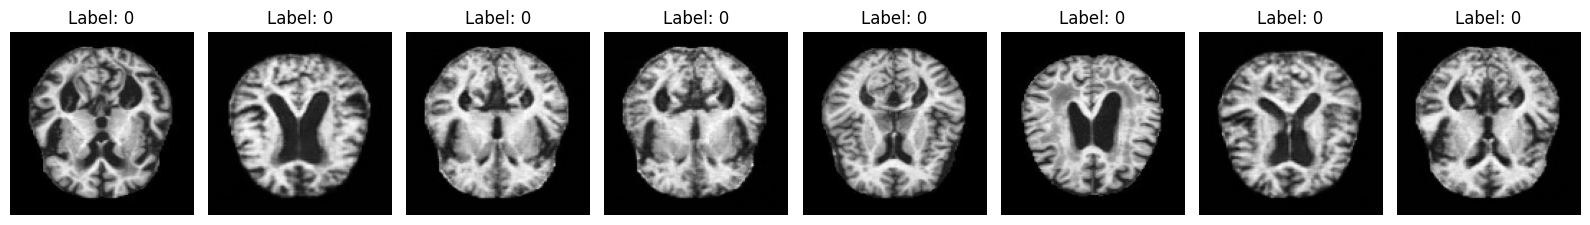

In [ ]:

    # Load image paths
    train_img_paths, train_labels, _ = load_image_paths_and_labels(train_dir)
    test_img_paths, test_labels, _ = load_image_paths_and_labels(test_dir)

    # Visualize sample images
    print("\n📊 Visualizing Sample MRI Scans with Brain Regions")
    visualize_sample_images(train_img_paths, train_labels)

    # Limit samples for memory constraints
    max_train_samples = 373
    max_test_samples = 100

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_mri_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size, color_mode='rgb')  # 'grayscale' if needed
        img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
        images.append(img_array)
    return np.array(images)


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

def load_tabular_data(csv_path, num_samples, scaler=None):
    df = pd.read_csv(csv_path)

    # Drop rows with missing values
    df = df.dropna()

    # Encode categorical variables
    df['M/F'] = LabelEncoder().fit_transform(df['M/F'])

    # Define features and target
    features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
    target = 'Group'

    # Convert target to binary: 1 = impaired, 0 = not impaired
    df[target] = df[target].map(lambda x: 0 if 'Nondemented' in x else 1)

    # Limit to `num_samples` to match image count
    df = df.iloc[:num_samples]

    X = df[features].values
    y = df[target].values

    # Scale features
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, y, scaler


In [ ]:
tabular_csv = '/content/alzheimer.csv'


In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def create_tabular_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x)


In [ ]:
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load training data
# Ensure consistent indentation for all lines within the main function
train_img_paths = train_img_paths[:max_train_samples]
X_img_train = load_mri_images(train_img_paths)
X_tab_train, y_train, scaler = load_tabular_data(tabular_csv, len(X_img_train))

# Load test data
test_img_paths = test_img_paths[:max_test_samples]
X_img_test = load_mri_images(test_img_paths)
# Pass the previously created scaler to ensure consistency between train and test scaling
X_tab_test, y_test, _ = load_tabular_data(tabular_csv, len(X_img_test), scaler)

# Create models
# Ensure image_model and tabular_model functions are defined and accessible
image_model = create_image_model()
tabular_model = create_tabular_model(X_tab_train.shape[1])
# Ensure build_multimodal_model function is defined and accessible
model = build_multimodal_model(image_model, tabular_model)

# Compile model
import tensorflow as tf # Import tf if not already globally imported
model.compile(optimizer=Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy',
                     tf.keras.metrics.AUC(name='auc')])

In [ ]:
min_samples = min(len(X_img_train), len(X_tab_train), len(y_train))

X_img_train = X_img_train[:min_samples]
X_tab_train = X_tab_train[:min_samples]
y_train = y_train[:min_samples]


In [ ]:



    # Train model
    print("\n🚀 Training the multimodal model...")
    history = model.fit(
        [X_img_train, X_tab_train],
        y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )


🚀 Training the multimodal model...
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5434 - auc: 0.5426 - loss: 0.6894 - val_accuracy: 0.5775 - val_auc: 0.6946 - val_loss: 0.6778
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 957ms/step - accuracy: 0.5742 - auc: 0.5115 - loss: 0.7021 - val_accuracy: 0.5634 - val_auc: 0.7201 - val_loss: 0.6753
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5635 - auc: 0.5691 - loss: 0.6837 - val_accuracy: 0.5775 - val_auc: 0.7556 - val_loss: 0.6728
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5333 - auc: 0.5462 - loss: 0.6983 - val_accuracy: 0.6056 - val_auc: 0.7671 - val_loss: 0.6707
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5214 - auc: 0.5446 - loss: 0.6907 - val_accuracy: 0.6056 - val_auc: 0.7815 - val_loss: 0.6688
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 971ms/step - accuracy: 0.5352 - auc: 0.5861 - loss: 0.6807 - val_accuracy: 0.6197 - val_auc: 0.8082 - val_loss: 0.6664
Epoch 7/30
9/9 ━━━━━━━━

In [ ]:
  # Evaluate model
print("\n🔍 Evaluating model performance...")
test_loss, test_acc, test_auc = model.evaluate([X_img_test, X_tab_test], y_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")


🔍 Evaluating model performance...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 768ms/step - accuracy: 0.8089 - auc: 0.8985 - loss: 0.5175

✅ Test Accuracy: 0.8400
✅ Test AUC: 0.9387


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 832ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.94      0.89        48
   Alzheimer       0.94      0.85      0.89        52

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


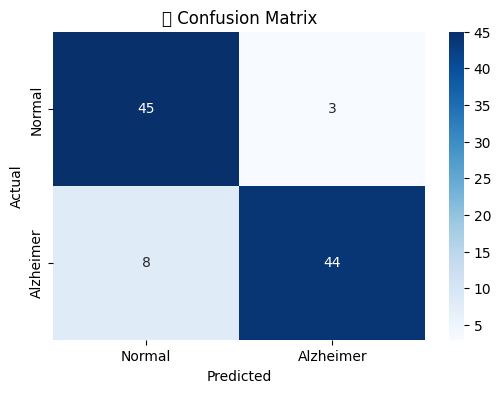

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


    # Generate predictions
y_pred = model.predict([X_img_test, X_tab_test])
y_pred_classes = (y_pred > 0.45).astype(int)

    # Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Alzheimer']))

    # Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Alzheimer'],
                yticklabels=['Normal', 'Alzheimer'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧠 Confusion Matrix")
plt.show()

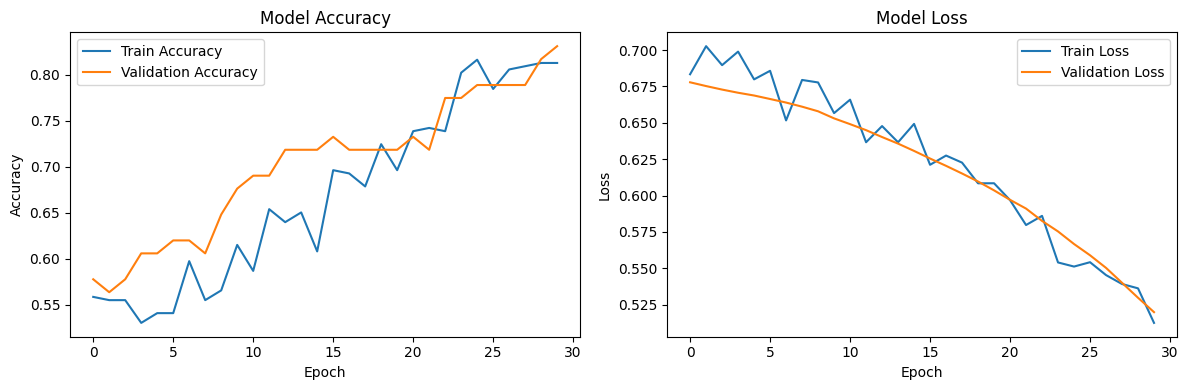

In [ ]:


    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
def visualize_feature_maps(model, img_array, layer_names):
    from tensorflow.keras.models import Model

    for layer_name in layer_names:
        intermediate_layer_model = Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(img_array)

        fig, axs = plt.subplots(1, min(4, intermediate_output.shape[-1]), figsize=(12, 4))
        fig.suptitle(f'Feature maps from {layer_name}', fontsize=14)

        for i in range(min(4, intermediate_output.shape[-1])):
            axs[i].imshow(intermediate_output[0, :, :, i], cmap='viridis')
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()



🔬 Visualizing Feature Extraction for Alzheimer's Detection
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


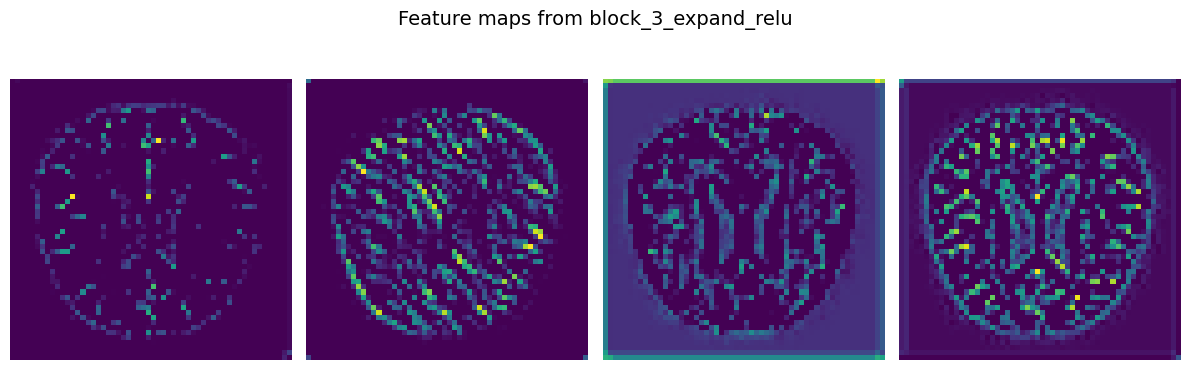

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


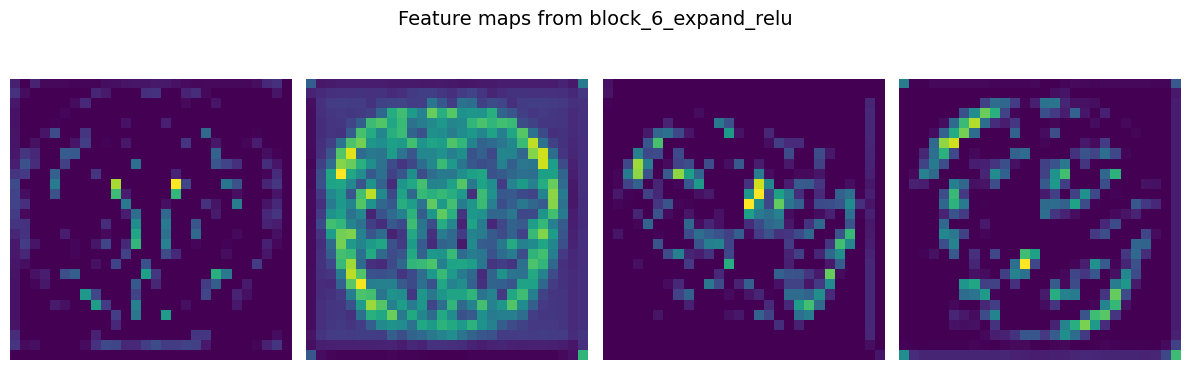

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


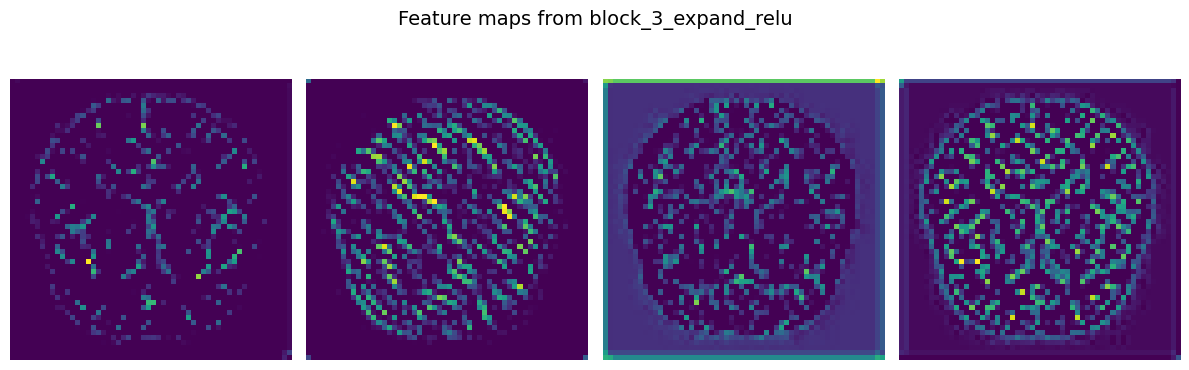

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


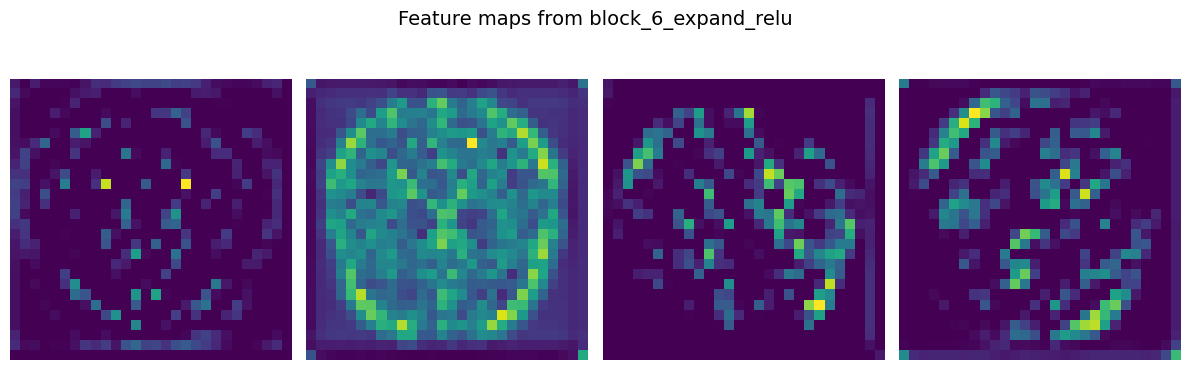


🎯 Making Sample Predictions with Visualization


<ipython-input-5-dbdd01838b3d>:67: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


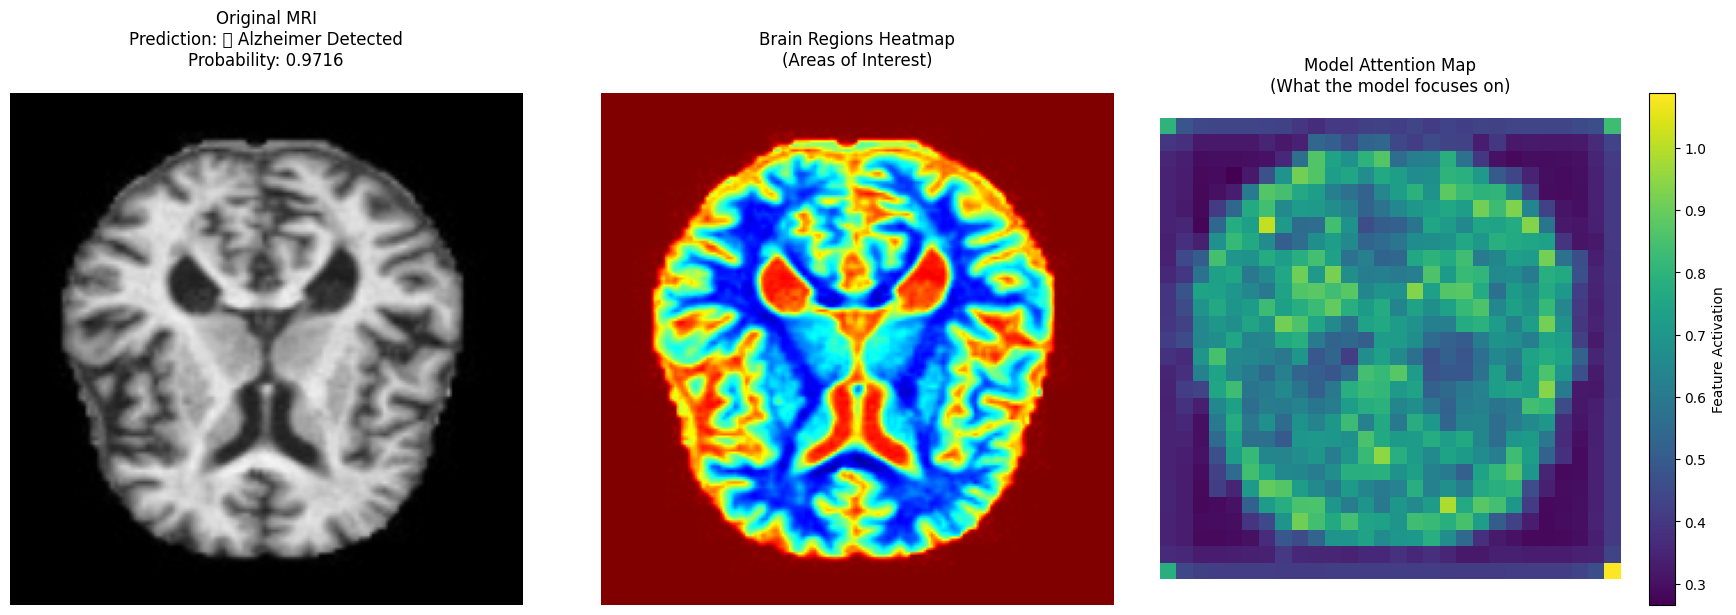


🧪 Prediction Probability: 0.9716
📣 Clinical Diagnosis: 🧠 Alzheimer Detected

Key Features Analysis:
- Significant hippocampal atrophy detected
- Ventricular enlargement present
- Cortical thinning observed
- Potential temporal lobe shrinkage


In [ ]:
print("\n🔬 Visualizing Feature Extraction for Alzheimer's Detection")
sample_indices = np.random.choice(len(X_img_test), 2, replace=False)
for idx in sample_indices:
    img_array = np.expand_dims(X_img_test[idx], axis=0)
    visualize_feature_maps(image_model, img_array, ['block_3_expand_relu', 'block_6_expand_relu'])


    # Make sample predictions with visualization
print("\n🎯 Making Sample Predictions with Visualization")
sample_idx = np.random.randint(len(X_img_test))
sample_img_path = test_img_paths[sample_idx]
sample_tab_data = X_tab_test[sample_idx]

predict_with_visualization(
        sample_img_path,
        sample_tab_data,
        model,
        scaler,
        image_model
    )

if __name__ == "__main__":
  main()